In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from scipy.stats import bootstrap

In [2]:

def _rounded_right_bar(ax, x_left, y_bottom, width, height, facecolor,
                       radius, n_arc=12, zorder=2):
    """
    Draw a rectangle at (x_left, y_bottom) with given width and height,
    but round only the right two corners with radius (data units).
    Suitable for horizontal bars.
    """
    # compute top and bottom in data coords
    top = max(y_bottom, y_bottom + height)
    bottom = min(y_bottom, y_bottom + height)
    h = top - bottom
    w = float(width)

    if h <= 1e-12 or w <= 0:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    # clamp radius
    r = min(radius, w / 2.0, h / 2.0)
    if r <= 1e-12:
        rect = plt.Rectangle((x_left, bottom), w, h,
                             facecolor=facecolor, edgecolor='none',
                             transform=ax.transData, zorder=zorder, clip_on=True)
        ax.add_patch(rect)
        return

    verts = []
    codes = []

    # Start at bottom-left
    verts.append((x_left, bottom)); codes.append(Path.MOVETO)
    verts.append((x_left, top)); codes.append(Path.LINETO)
    verts.append((x_left + w - r, top)); codes.append(Path.LINETO)

    # top-right quarter circle (angles pi/2 -> 0), center = (x_left + w - r, top - r)
    cx_tr = x_left + w - r
    cy_tr = top - r
    ts = np.linspace(0.5 * np.pi, 0, n_arc)
    for t in ts:
        verts.append((cx_tr + r * np.cos(t), cy_tr + r * np.sin(t)))
        codes.append(Path.LINETO)

    # bottom-right quarter circle (angles 0 -> -pi/2), center = (x_left + w - r, bottom + r)
    cx_br = x_left + w - r
    cy_br = bottom + r
    ts = np.linspace(0, -0.5 * np.pi, n_arc)
    for t in ts:
        verts.append((cx_br + r * np.cos(t), cy_br + r * np.sin(t)))
        codes.append(Path.LINETO)

    # back to bottom-left
    verts.append((x_left, bottom)); codes.append(Path.LINETO)
    verts.append((x_left, bottom)); codes.append(Path.CLOSEPOLY)

    path = Path(verts, codes)
    patch = PathPatch(path, facecolor=facecolor, edgecolor='none',
                      transform=ax.transData, zorder=zorder, clip_on=True)
    ax.add_patch(patch)

# Example plotting function for horizontal bars
def plot_horizontal_data(ax, data, y_tick_labels=None, x_label=None,
                         titles=None, bar_colors=None, tick_params=None,
                         title_params=None, bar_params=None,
                         error_bar_params=None, xlims=None,
                         single_point_size=18, best_indcs=None):

    if not bar_params:
        bar_params = dict()
    if not error_bar_params:
        error_bar_params = dict()

    bar_height = bar_params.get('bar_height', 0.4)
    bar_radius_fac = bar_params.get('bar_radius_fac', 0.18)

    error_lw = error_bar_params.get('error_lw', 1.5)
    error_cs = error_bar_params.get('error_cs', 6)

    if not bar_colors:
        bar_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"][:len(data)]

    y_positions = np.arange(len(data))

    means, cis_lower, cis_upper = [], [], []
    ci = 0.9

    if not best_indcs:
        best_indcs = [None for _ in range(len(data))]

    for i, (values, best_idx) in enumerate(zip(data, best_indcs)):
        mean = np.mean(values)
        if np.size(values) > 1:
            res = bootstrap((np.asarray(values),), np.mean,
                            confidence_level=ci, n_resamples=10000,
                            method='percentile', random_state=42)
            ci_low, ci_high = res.confidence_interval
        else:
            ci_low, ci_high = mean, mean

        means.append(mean)
        cis_lower.append(mean - ci_low)
        cis_upper.append(ci_high - mean)

        # jittered scatter of raw points (centered on the bar)
        spread = np.linspace(-bar_height / 2.2, bar_height / 2.2, len(values))
        if best_idx is None:
            ax.scatter(values, y_positions[i] + spread, s=single_point_size, c='white', alpha=0.75, zorder=50,
                       edgecolors='black', linewidths=1.)
        else:
            for j, v in enumerate(values):
                if j == best_idx:
                    ax.scatter(v, y_positions[i] + spread[j], s=single_point_size*4, c=bar_colors[i], alpha=0.75, zorder=50, marker='*',
                               edgecolors='black', linewidths=1.) #'#46B56B'
                else:
                    # add edge to non-best points
                    ax.scatter(v, y_positions[i] + spread[j], s=single_point_size, c=bar_colors[i], alpha=0.75, zorder=50,
                               edgecolors='black', linewidths=1.)

    # Draw rounded-right bars
    radius = bar_height * bar_radius_fac
    for i in range(len(data)):
        y_bottom = y_positions[i] - bar_height / 2.0
        _rounded_right_bar(ax, 0., y_bottom, means[i], bar_height,
                           facecolor=bar_colors[i], radius=radius, n_arc=14, zorder=2)

    # draw errorbars
    for i in range(len(data)):
        ax.errorbar(means[i], y_positions[i],
                    xerr=[[cis_lower[i]], [cis_upper[i]]],
                    fmt='none', ecolor='k', elinewidth=error_lw, capsize=error_cs, zorder=10, alpha=0.75)

    # Style polish
    ax.grid(True, linestyle='--', alpha=0.55, axis='x')
    ax.set_yticks(y_positions)
    if titles:
        ax.set_yticklabels(titles, fontsize=tick_params.get('labelsize', 10) if tick_params else 10)

    ax.set_xlabel(x_label, fontsize=tick_params.get('labelsize', 10) if tick_params else 10)
    # if title:
    #     ax.text(s=title, zorder=100, **title_params if title_params else {})

    if tick_params:
        ax.tick_params(**tick_params)
    if xlims:
        ax.set_xlim(xlims)
    ax.set_ylim(-0.5, len(data) - 0.5) 


In [3]:
#'min_distance'

def extract_metric(file_path, metric_key='R2', normal_fidelity=False):
    with open(file_path, 'r') as f:
        data = json.load(f)
    result = data.get('result', {})
    mse = result.get(metric_key, None)
    if metric_key =='log_fidelity' and normal_fidelity:
        N = result['N']
        mse = np.exp(mse * N)
    return mse


# Waves

In [4]:
saved_paths = [ './waves_final_runs']
contained_in_name = 'run'
average_func = np.mean
sub_folders_to_consider =["LIN_SEQ","LIN_SEQ_NNN","LIN_SEQ_POTENTIAL","LIN_SEQ_PERIODIC",
       "NONLIN_SEQ" ,"NONLIN_SEQ_NNN", "NONLIN_SEQ_POTENTIAL", "NONLIN_SEQ_PHI6", 
       "SIMPLE_GL","COMPLEX_GL", "COMPLEX_GL_NNN", "SIN_POTENTIAL_RELAXATION", 
      ]
labels = ["Linear Schröd.","Linear Schröd.\nwith NNN",
          "Linear Schröd.\nwith confining pot.", "Linear Schröd.\nwith periodic pot.",

          "Nonlinear Schröd.", "Nonlinear Schröd.\nwith NNN", 
          "Nonlinear Schröd.\nwith confining pot.", "Nonlinear Schröd.\nwith $\phi^6$ term",

          "Real\nGinzburg-Landau", "Complex\nGinzburg-Landau", 
          "Complex Ginzburg-\nLandau with NNN", "Sinusoidal\npot. relaxation",
          ]
names_for_legend =  labels.copy()

<>:12: SyntaxWarning: invalid escape sequence '\p'
<>:12: SyntaxWarning: invalid escape sequence '\p'
/var/folders/bl/g1q9c8kd65d4_zy09smb8lgdfdw6x5/T/ipykernel_47555/1523633735.py:12: SyntaxWarning: invalid escape sequence '\p'
  "Nonlinear Schröd.\nwith confining pot.", "Nonlinear Schröd.\nwith $\phi^6$ term",


In [5]:
data_all_unproc = {}
best_idcs = {}
for saved_path in saved_paths[:]:
    for sub_folder in sub_folders_to_consider:
        if not os.path.exists(os.path.join(saved_path, sub_folder)):
            continue
        folders = os.listdir(os.path.join(saved_path, sub_folder))
        filtered_files = sorted([os.path.join(saved_path, sub_folder, f) for f in folders if contained_in_name in f])
        data_unproc = [extract_metric(f, 'R2') for f in filtered_files]
        data_all_unproc[sub_folder] = data_unproc


data_all_proc= {}
for key, data in data_all_unproc.items():
    data_all_proc[key] = np.clip(np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0), 0.0, 1.0)

Figure size in points: 475.0 262.5
Figure size in in: 6.597222222222222 3.645833333333333


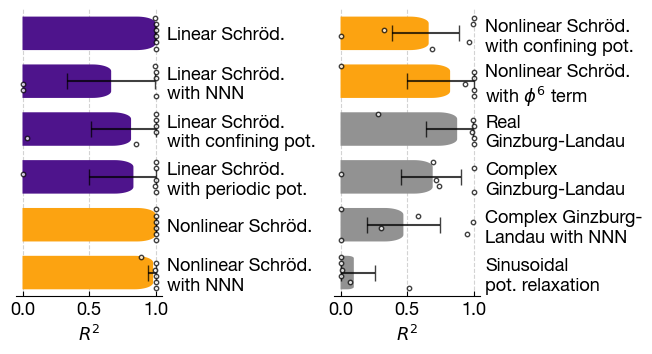

In [ ]:
# ------------------ your plotting (drop-in) ------------------
import copy
font = "Helvetica Neue"
plt.rcParams.update({
    "text.usetex": False,   # Let Matplotlib handle fonts
    "font.family": "sans-serif",
    "font.sans-serif": [font,]
})
cm = 1/2.54  # centimeters in inches
pts_inch = 72.  # points in inches
# width = 15 * cm
# height = 7.5 * cm
width = 475/ pts_inch  # 1 column
height = 350 / pts_inch * (len(data_all_proc)/16)# half page

print("Figure size in points:", width*72, height*72)  # 1 inch = 72 points
print("Figure size in in:", width, height)  # 1 inch = 2.54 cm
col1 = "#4e148c"
col2 = '#fca311' 
col3 = '#929292'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(width, height))

for i, axs in enumerate(axes):

  full_data = []
  best_i = []
  for sub_folder in sub_folders_to_consider[:len(sub_folders_to_consider)//2] if i == 0 else sub_folders_to_consider[len(sub_folders_to_consider)//2:]:
      full_data.append(data_all_proc.get(sub_folder, []))
      best_i.append(best_idcs.get(sub_folder, None))
  #full_data = np.array(full_data)
    # just to demo multiple subplots


  tick_params = {'axis': 'both', 'which': 'major', 'labelsize': 13, 'direction': 'in','labelleft':False,'labelbottom':True, 'labelright':True,
                'right': False, 'top': False, 'left': False}
  title_params = {'size': 13, 'x':0.5, 'y':1.1, 'ha':'center', 
                  'bbox': None,}#dict(boxstyle="round,pad=0.1", fc="white", ec="black", lw=0.5, alpha=0.75)}
  error_bar_params = {'error_lw': 1.5, 'error_cs': 6}
  bar_params = dict(bar_height=0.7, bar_radius_fac=0.2)

  if i == 0:
      bar_colors = [col2] * 2 + [col1]* 4
  else:
      bar_colors = [col3]* 4 + [col2] * 2 

  y_lims = (-0.05, 1.05)
  single_point_size= 10
  spec_tick_params = copy.deepcopy(tick_params)
  if i == 0:
      lab = names_for_legend[:len(names_for_legend)//2]
  else:
      lab = names_for_legend[len(names_for_legend)//2:]

  full_data.reverse()
  lab.reverse()
  plot_horizontal_data(axs, full_data, y_tick_labels=[""]* len(full_data), x_label="$R^2$", titles=lab, bar_colors=bar_colors, 
          tick_params=spec_tick_params, title_params=title_params, bar_params=bar_params, error_bar_params=error_bar_params, xlims=y_lims,
          single_point_size=single_point_size, best_indcs=best_i)
  axs.set_xticks([0.0, 0.5, 1.0])
  axs.set_xticklabels(['0.0', '0.5', '1.0'])
  axs.spines['top'].set_visible(False)
  axs.spines['right'].set_visible(False)
  axs.spines['left'].set_visible(False)
  fig.tight_layout()
  plt.savefig('wave_results.pdf', dpi=300, transparent=True, bbox_inches='tight')